In [1]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
latent_dim = 100

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    # define one block
    def block(input_dim, output_dim, normalize=True):
      layers = [nn.Linear(input_dim, output_dim)]
      if normalize:
        # BatchNorm with epsilon=0.8
        layers.append(nn.BatchNorm1d(output_dim, 0.8))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    self.model = nn.Sequential(
        *block(latent_dim, 128, normalize=False),
        *block(128, 256),
        *block(256, 512),
        *block(512, 1024),
        nn.Linear(1024, 1 * 28 * 28),
        nn.Tanh()
    )
  def forward(self, z):
    img = self.model(z)
    img = img.view(img.size(0), 1, 28, 28) # img.size(0) = batch_size
    return img

In [4]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(1 * 28 * 28, 512),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(512, 256),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Linear(256, 1),
        nn.Sigmoid(),
    )

  def forward(self, img):
    flattened = img.view(img.size(0), -1)
    output = self.model(flattened)

    return output

In [5]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], 0.5)
])

train_dataset = datasets.MNIST(root="./datasets", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



In [6]:
print(len(dataloader))

469


In [7]:
# initialize
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# loss function
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

lr = 0.0002

# Adam optimizer
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [9]:
import time

n_epochs = 200
sample_interval = 2000 
start_time = time.time()

for epoch in range(n_epochs):
  for i, (imgs, _) in enumerate(dataloader):

    # labeling
    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # real: 1
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # fake: 0

    real_imgs = imgs.cuda()

    optimizer_G.zero_grad()

    z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda() # imgs.shape = number of images

    generated_imgs = generator(z)

    g_loss = adversarial_loss(discriminator(generated_imgs), real)

    g_loss.backward()
    optimizer_G.step()

    optimizer_D.zero_grad()

    real_loss = adversarial_loss(discriminator(real_imgs), real)
    fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
    d_loss = (real_loss + fake_loss) / 2

    # 판별자(discriminator) 업데이트
    d_loss.backward()
    optimizer_D.step()

    done = epoch * len(dataloader) + i
    if done % sample_interval == 0:
      # 생성된 이미지 중에서 25개만 선택하여 5 x 5 격자 이미지에 출력
      save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

  # 하나의 epoch이 끝날 떄마다 로그(log) 출력
  print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.480428] [G loss: 1.593093] [Elapsed time: 13.62s]
[Epoch 1/200] [D loss: 0.288334] [G loss: 1.806768] [Elapsed time: 27.91s]
[Epoch 2/200] [D loss: 0.343145] [G loss: 1.483130] [Elapsed time: 42.81s]
[Epoch 3/200] [D loss: 0.226812] [G loss: 1.287224] [Elapsed time: 56.92s]
[Epoch 4/200] [D loss: 0.110569] [G loss: 3.704772] [Elapsed time: 70.90s]
[Epoch 5/200] [D loss: 0.496791] [G loss: 0.584024] [Elapsed time: 84.96s]
[Epoch 6/200] [D loss: 0.284532] [G loss: 1.129428] [Elapsed time: 98.78s]
[Epoch 7/200] [D loss: 0.214409] [G loss: 1.761881] [Elapsed time: 112.86s]
[Epoch 8/200] [D loss: 0.317274] [G loss: 3.268346] [Elapsed time: 126.82s]
[Epoch 9/200] [D loss: 0.177261] [G loss: 2.026747] [Elapsed time: 141.12s]
[Epoch 10/200] [D loss: 0.184868] [G loss: 2.610692] [Elapsed time: 156.17s]
[Epoch 11/200] [D loss: 0.134015] [G loss: 2.810412] [Elapsed time: 170.32s]
[Epoch 12/200] [D loss: 0.110236] [G loss: 2.877262] [Elapsed time: 184.52s]
[Epoch 13/200] [

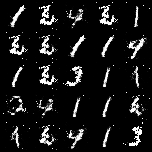

In [14]:
from IPython.display import Image

Image('92000.png')